In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras.activations import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,LSTM,GRU
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score ,confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
x_train = pd.read_csv(r"/kaggle/input/hijja-dataset/train_X.csv",header=None)
y_train = pd.read_csv(r"/kaggle/input/hijja-dataset/train_Y.csv",header=None)

x_test = pd.read_csv(r"/kaggle/input/hijja-dataset/test_X.csv",header=None)
y_test = pd.read_csv(r"/kaggle/input/hijja-dataset/test_Y.csv",header=None)

print("x_train.shape =", x_train.shape, "\ny_train.shape =", 
      y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (37933, 1024) 
y_train.shape = (37933, 1) 
x_test.shape = (9501, 1024) 
y_test.shape = (9501, 1)


In [3]:
x_train = x_train.iloc[:,:].values
x_test = x_test.iloc[:,:].values
y_train = y_train.iloc[:,:].values
y_test = y_test.iloc[:,:].values
print("x_train.shape =", x_train.shape, "\ny_train.shape =", 
      y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (37933, 1024) 
y_train.shape = (37933, 1) 
x_test.shape = (9501, 1024) 
y_test.shape = (9501, 1)


In [4]:
x_train = x_train.reshape(-1,32,32,1)
x_test = x_test.reshape(-1,32,32,1)

x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape, x_test.shape)

(37933, 32, 32, 1) (9501, 32, 32, 1)


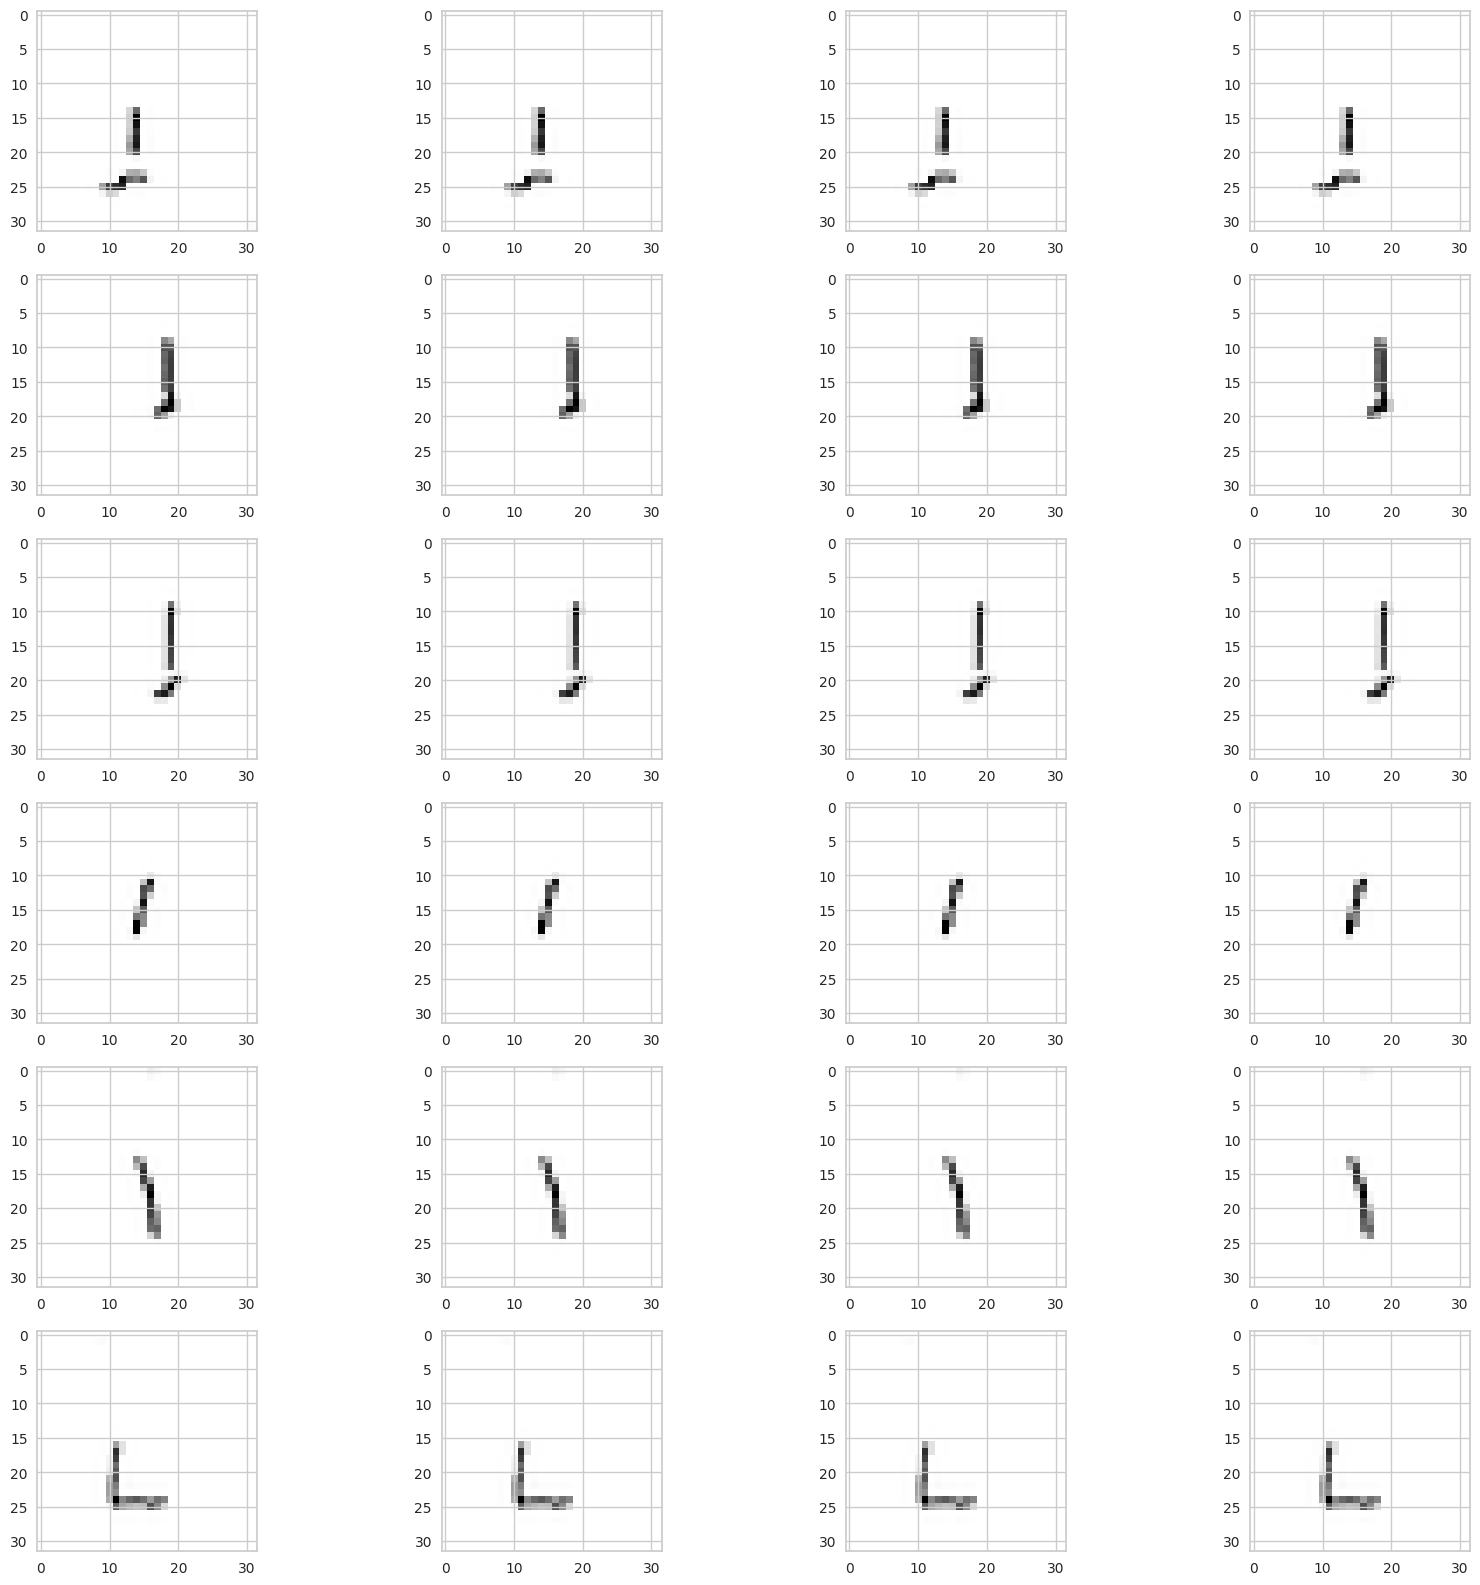

In [5]:
fig, ax = plt.subplots(6,4,figsize=(20,20))

for i in range(6):
    for j in range(4):
        ax[i,j].imshow(x_train[i])

In [6]:
total_classes = len(np.unique(y_train))+1
y_train = to_categorical(y_train,total_classes)
y_test = to_categorical(y_test, total_classes)

print(y_train.shape)
print(y_test.shape)

(37933, 30)
(9501, 30)


In [7]:
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input,Conv1D,Flatten,BatchNormalization,SpatialDropout1D, MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
class attention(layers.Layer):
    def _init_(self,**kwargs):
        super(attention,self)._init_(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [8]:
model = Sequential([
    
    
    LSTM(256, return_sequences=True, dropout=0.25, input_shape=(32,32)),
    Dense(256, activation='relu'),
    
    LSTM(128, return_sequences=True, dropout=0.5),
    Dense(128, activation='relu'),
    
    LSTM(64, return_sequences=True, dropout=0.5),
    Dense(64, activation='relu'),
    
    LSTM(32, return_sequences=True, dropout=0.5),
    Dense(32, activation='relu'),
    
    attention(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(total_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 256)           295936    
                                                                 
 dense (Dense)               (None, 32, 256)           65792     
                                                                 
 lstm_1 (LSTM)               (None, 32, 128)           197120    
                                                                 
 dense_1 (Dense)             (None, 32, 128)           16512     
                                                                 
 lstm_2 (LSTM)               (None, 32, 64)            49408     
                                                                 
 dense_2 (Dense)             (None, 32, 64)            4160      
                                                                 
 lstm_3 (LSTM)               (None, 32, 32)            1

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

In [10]:
history = model.fit(x_train,y_train,
                    #steps_per_epoch=len(x_train)//128,
                    batch_size=128,
                    epochs=150,
                    validation_data=(x_test, y_test),
                   # validation_steps=50
                   )

Epoch 1/150
297/297 [==============================] - 20s 24ms/step - loss: 3.0937 - accuracy: 0.1088 - val_loss: 2.7022 - val_accuracy: 0.1735
Epoch 2/150
297/297 [==============================] - 6s 19ms/step - loss: 2.4807 - accuracy: 0.2287 - val_loss: 2.2518 - val_accuracy: 0.2902
Epoch 3/150
297/297 [==============================] - 6s 19ms/step - loss: 2.1649 - accuracy: 0.3171 - val_loss: 1.9269 - val_accuracy: 0.3836
Epoch 4/150
297/297 [==============================] - 6s 19ms/step - loss: 1.9571 - accuracy: 0.3780 - val_loss: 1.6383 - val_accuracy: 0.4803
Epoch 5/150
297/297 [==============================] - 6s 19ms/step - loss: 1.7716 - accuracy: 0.4422 - val_loss: 1.5200 - val_accuracy: 0.5109
Epoch 6/150
297/297 [==============================] - 6s 19ms/step - loss: 1.6229 - accuracy: 0.4868 - val_loss: 1.3582 - val_accuracy: 0.5712
Epoch 7/150
297/297 [==============================] - 6s 19ms/step - loss: 1.5137 - accuracy: 0.5212 - val_loss: 1.2133 - val_accuracy

In [11]:
y_held_pred=model.predict(x_test)

297/297 [==============================] - 3s 6ms/step


In [12]:
y_pred=np.argmax(y_held_pred, axis=1)
y_test_1=np.argmax(y_test, axis=1)

print(y_test_1.shape)
print(y_pred.shape)

(9501,)
(9501,)


In [13]:
model.evaluate(x_test,y_test)

297/297 [==============================] - 2s 7ms/step - loss: 0.6090 - accuracy: 0.8457


[0.6089514493942261, 0.8457004427909851]

In [14]:
his=model.evaluate(x_test, y_test, verbose=2);
print(his)

297/297 - 2s - loss: 0.6090 - accuracy: 0.8457 - 2s/epoch - 7ms/step
[0.6089514493942261, 0.8457004427909851]


In [15]:
y_held_pred_train=model.predict(x_train)

1186/1186 [==============================] - 8s 6ms/step


In [16]:
y_pred_train=np.argmax(y_held_pred_train, axis=1)
y_train_1=np.argmax(y_train, axis=1)

print(y_train_1.shape)
print(y_pred_train.shape)
model.evaluate(x_train, y_train, verbose=2);

(37933,)
(37933,)
1186/1186 - 8s - loss: 0.1207 - accuracy: 0.9615 - 8s/epoch - 7ms/step


<Axes: title={'center': 'Actual vs. Predicted'}, xlabel='Actual G*', ylabel='Predicted G*'>

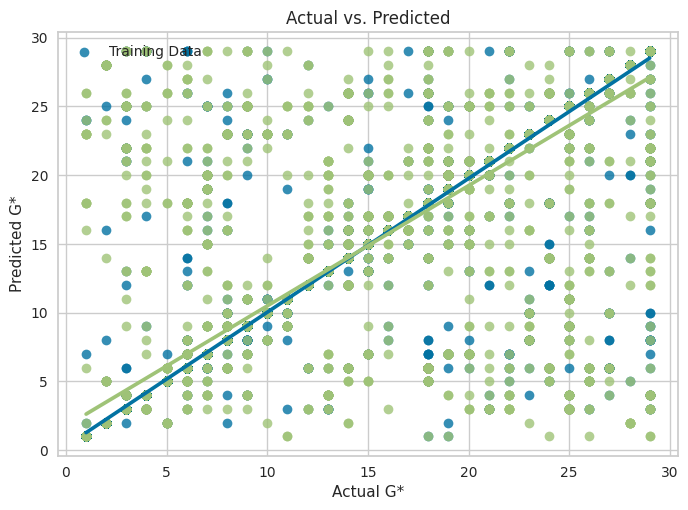

In [17]:
import seaborn as sns

sns.regplot(x=y_train_1,y=y_pred_train, label="Training Data")

plt.xlabel('Actual G*')
plt.ylabel('Predicted G*')
plt.title('Actual vs. Predicted')
plt.legend(loc="upper left")

sns.regplot(x=y_test_1,y=y_pred, label="Testing Data")

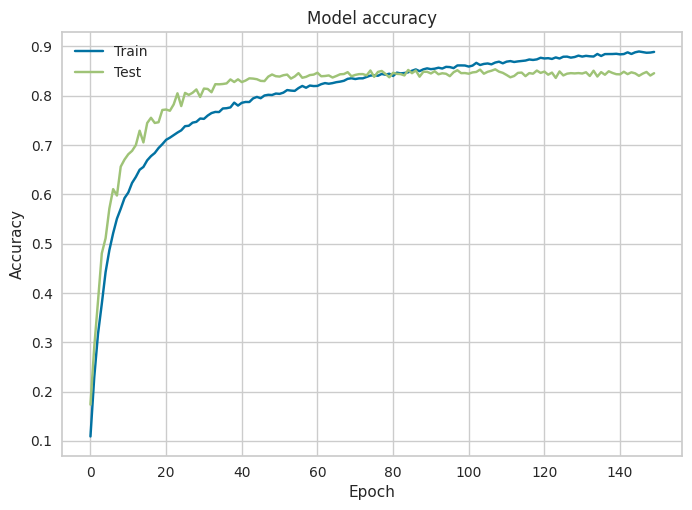

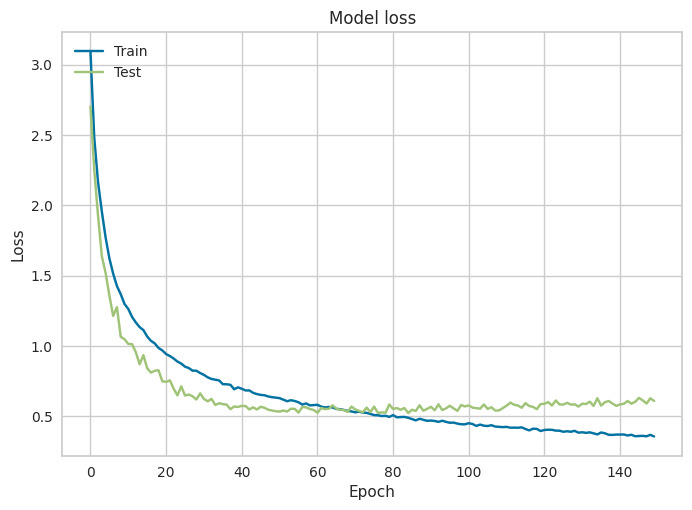

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
y_predicted = model.predict(x_test)
y_grand_truth = y_test
y_predicted = np.argmax(y_predicted,axis=1)
y_grand_truth = np.argmax(y_grand_truth,axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_grand_truth, y_predicted)

297/297 [==============================] - 2s 7ms/step


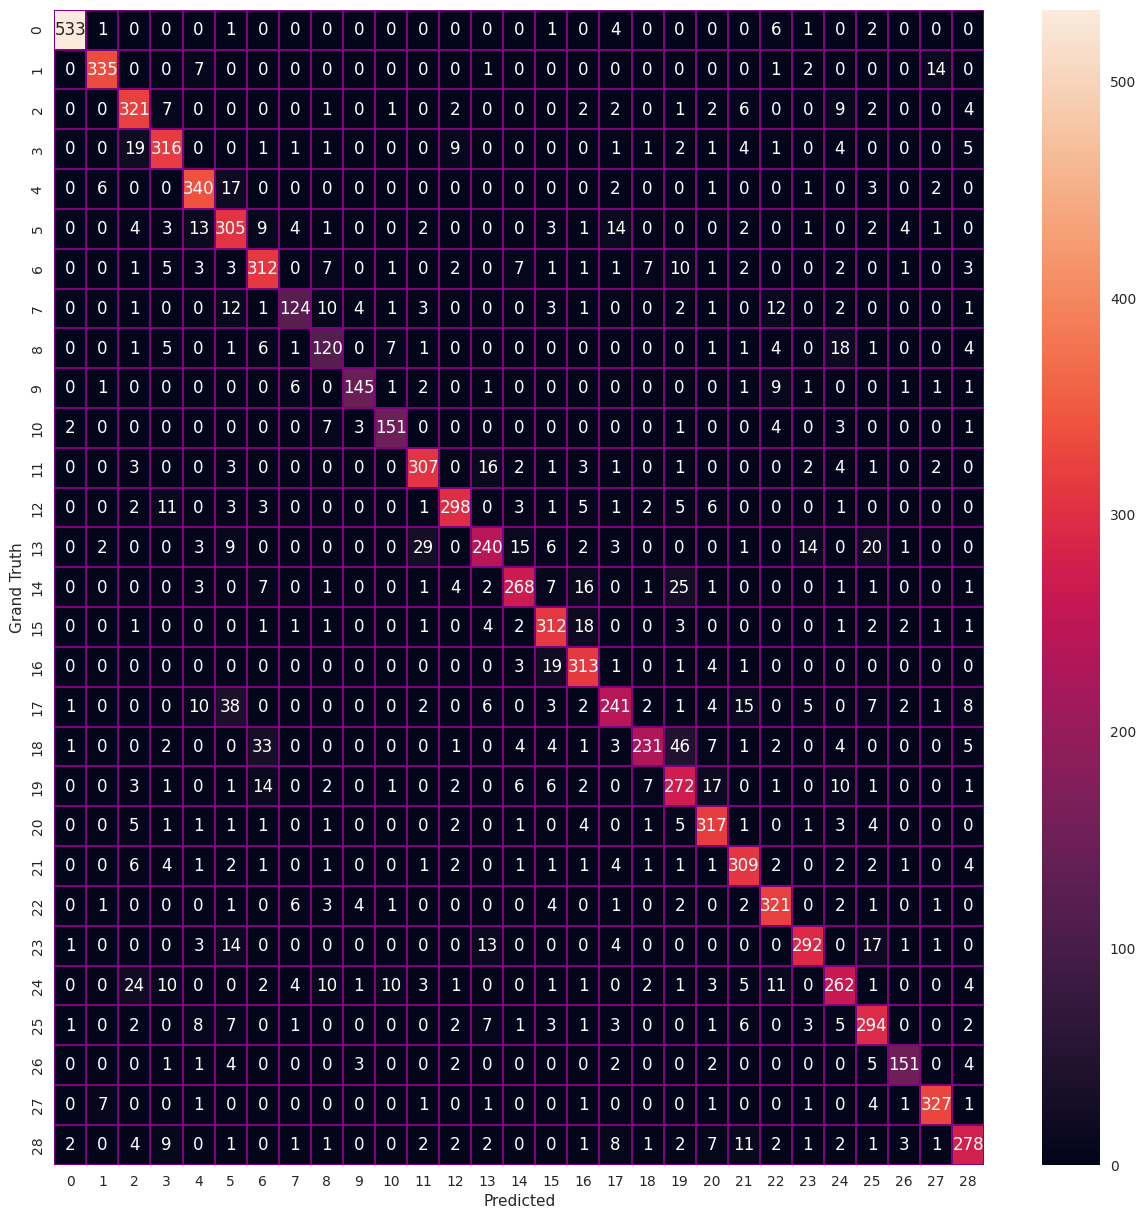

In [20]:
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.2, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

In [21]:
scores = np.zeros((28,3))
def calc_F1(num):
  TP = cm[num,num]
  FN = np.sum(cm[num,:])-cm[num,num]
  FP = np.sum(cm[:,num])-cm[num,num]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1_score = 2*(recall * precision) / (recall + precision)
  return precision, recall, F1_score
for i in range(28):
   precision, recall, F1_score = calc_F1(i)
   scores[i,:] = precision, recall, F1_score
scores_frame = pd.DataFrame(scores,columns=["Precision", "Recall", "F1 Score"], index=[list(range(0, 28))])

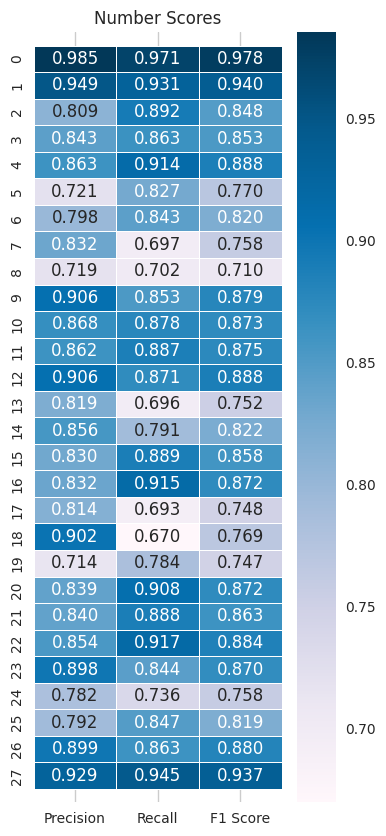

In [22]:
f, ax = plt.subplots(figsize = (4,10))
ax.set_title('Number Scores')
sns.heatmap(scores_frame, annot=True, fmt=".3f", linewidths=0.5, cmap="PuBu", cbar=True, ax=ax)
bottom, top = ax.get_ylim()
plt.ylabel("")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [23]:
# Functions: Performance Evaluation 

def Performance(Model , y_predd): 
    
    # model accuracy
    accuracy = accuracy_score(y_test_1, y_predd)
    print( Model +' Accuracy:'+'\033[1m {:.2f}%'.format(accuracy*100))
    
    # model Classification Report
    print('\nClassification Report: '+'\033[0m')
    print('*' * 22)
    print(classification_report(y_test_1, y_predd))

In [24]:
Performance('LSTM' , y_pred)

LSTM Accuracy: 84.57%

Classification Report: 
**********************
              precision    recall  f1-score   support

           1       0.99      0.97      0.98       549
           2       0.95      0.93      0.94       360
           3       0.81      0.89      0.85       360
           4       0.84      0.86      0.85       366
           5       0.86      0.91      0.89       372
           6       0.72      0.83      0.77       369
           7       0.80      0.84      0.82       370
           8       0.83      0.70      0.76       178
           9       0.72      0.70      0.71       171
          10       0.91      0.85      0.88       170
          11       0.87      0.88      0.87       172
          12       0.86      0.89      0.87       346
          13       0.91      0.87      0.89       342
          14       0.82      0.70      0.75       345
          15       0.86      0.79      0.82       339
          16       0.83      0.89      0.86       351
          1







### 